In [1]:
!pip install kaggle


In [3]:
import os

# Create Kaggle directory
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Save kaggle.json file (Paste your JSON content here)
kaggle_json = '''{
    "username": "your_kaggle_username",
    "key": "your_kaggle_key"
}'''
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as file:
    file.write(kaggle_json)

# Set appropriate permissions
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)


In [5]:
!kaggle datasets download -d kazanova/sentiment140


Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
from zipfile import ZipFile

dataset = "sentiment140.zip"  # Replace with your downloaded dataset file name
with ZipFile(dataset, 'r') as zip_ref:
    zip_ref.extractall("sentiment140")  # Specify the output folder if needed
    print("Dataset extracted successfully!")


Dataset extracted successfully!


In [9]:
import os
os.listdir("sentiment140")  # Replace with your output folder name



['.ipynb_checkpoints', 'training.1600000.processed.noemoticon.csv']

In [11]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Komal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# print(stopwords.words('english'))
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

load the data from csv to pandas dataframe

In [79]:
import pandas as pd
df1=pd.read_csv('data.csv',encoding='ISO-8859-1')
df=df1.sample(n=10000,random_state=42)
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"
...,...,...,...,...,...,...
965972,4,1827657114,Sun May 17 11:10:20 PDT 2009,NO_QUERY,Jaydeeman2009,@keisha_buchanan lol are u talking TV as in sc...
1193435,4,1984262616,Sun May 31 14:45:44 PDT 2009,NO_QUERY,dauria,@addieking you are SO welcome
896390,4,1693023092,Sun May 03 21:21:46 PDT 2009,NO_QUERY,efflovexo,is snugglin with her little girl .. had a busy...
544127,0,2201006002,Tue Jun 16 19:40:29 PDT 2009,NO_QUERY,aNii_lovee,@ladygagafan1 sad because I do not have the ne...


checking no of rows and columns

In [57]:
df.shape

(10000, 6)

In [59]:
df.size

60000

In [61]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"


Naming the columns and reading the dataset again

In [85]:
column_names=['target','id','date','flag','user','text']
df1=pd.read_csv('data.csv',names=column_names,encoding='ISO-8859-1')
df=df1.sample(n=10000,random_state=42)
df

,target,id,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
...,...,...,...,...,...,...
965972,4,1827657080,Sun May 17 11:10:20 PDT 2009,NO_QUERY,Hici96,"My sister, Cheyenne's birthday party is today!..."
1193436,4,1984262616,Sun May 31 14:45:44 PDT 2009,NO_QUERY,dauria,@addieking you are SO welcome
896390,4,1693023020,Sun May 03 21:21:45 PDT 2009,NO_QUERY,evankmathews,@RebekahMaylene seriously!! Those gals were ma...
544127,0,2201005638,Tue Jun 16 19:40:27 PDT 2009,NO_QUERY,jimbafrosty,@SarahMascara thanks now i want chicken and ch...


In [64]:
df.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

In [87]:
df.shape

(10000, 6)

In [89]:
df.head()

,target,id,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


Deal with missing values

In [71]:
df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [93]:
df['target'].value_counts()

target
0    5004
4    4996
Name: count, dtype: int64

In [91]:
df['target'].unique()

array([0, 4], dtype=int64)

0 is for negative and 4 is for positive

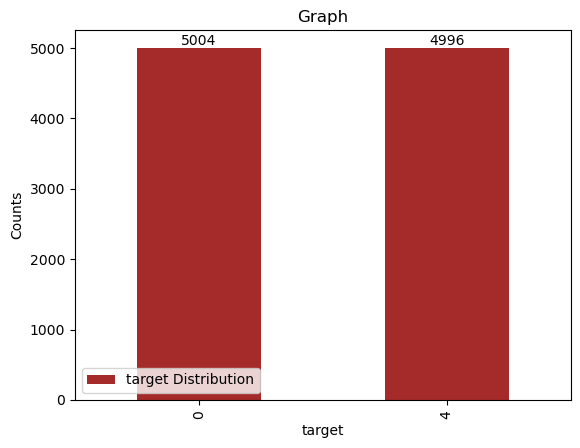

In [131]:
import matplotlib.pyplot as plt
counts=df['target'].value_counts()
ax=counts.plot.bar(color='brown',label="target Distribution")
plt.xlabel('target')
plt.ylabel('Counts')
plt.title('Graph')
ax.bar_label(ax.containers[0])
plt.legend()
plt.show()

convert the target from 4 to 1

In [ ]:
df.replace({'target':{4:1}},inplace=True)

In [ ]:
df['target'].value_counts()

0:negative tweet 
1:positive tweets

In [ ]:
port_stem=PorterStemmer()

In [147]:
def stemming(content):
    stemmed_content=re.sub('[^a-zA-Z]',' ',content)
    stemmed_content=stemmed_content.lower()
    stemmed_content=stemmed_content.split()
    stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content=' '.join(stemmed_content)
    return stemmed_content

In [149]:
df['stemmed_content']=df['text'].apply(stemming)

In [137]:
port_stem = PorterStemmer()


In [143]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [145]:

df['text'] = df['text'].fillna('').astype(str)


In [151]:
df.head()

,target,id,date,flag,user,text,stemmed_content
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,chrishasboob ahhh hope ok
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",misstoriblack cool tweet app razr
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,tiannachao know famili drama lame hey next tim...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email open geographi stuff revis stupid...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airway problem


In [153]:
print(df['stemmed_content'])

541200                             chrishasboob ahhh hope ok
750                        misstoriblack cool tweet app razr
766711     tiannachao know famili drama lame hey next tim...
285055     school email open geographi stuff revis stupid...
705995                                  upper airway problem
                                 ...                        
965972     sister cheyenn birthday parti today gonna much...
1193436                                        addiek welcom
896390     rebekahmaylen serious gal make nervou parti th...
544127     sarahmascara thank want chicken cheesecak toge...
117202     kutefan sadli probabl true tri trident competi...
Name: stemmed_content, Length: 10000, dtype: object


In [157]:
df.replace({'target':{4:1}},inplace=True)

In [165]:
df.replace({'target':{4:1}},inplace=True)

In [167]:
df['target']

541200     0
750        0
766711     0
285055     0
705995     0
          ..
965972     1
1193436    1
896390     1
544127     0
117202     0
Name: target, Length: 10000, dtype: int64

In [169]:
X=df['stemmed_content'].values
Y=df['target'].values

In [171]:
X

array(['chrishasboob ahhh hope ok', 'misstoriblack cool tweet app razr',
       'tiannachao know famili drama lame hey next time u hang kim n u guy like sleepov whatev ill call u',
       ..., 'rebekahmaylen serious gal make nervou parti thank come',
       'sarahmascara thank want chicken cheesecak togeath though',
       'kutefan sadli probabl true tri trident competit get beyonc ticket last chanc'],
      dtype=object)

In [173]:
Y

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

splitting the data to training and testing

In [182]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)


In [186]:
X.shape,X_train.shape,X_test.shape

((10000,), (8000,), (2000,))

In [188]:
X_train

array(['misschrii know celebr yet lol excit', 'mani mask festiv',
       'g mornin everyon feelin bit better morn', ...,
       'jerquiaga keep breath',
       'emeraldangeluk uk terrtenti downpour oh joy',
       'tracecyru http twitpic com ea still sweeter'], dtype=object)

In [190]:
X_test

array(['love sunni day fife today shame work',
       'punch lever thing fall back onto sensor measur strength punch could never beat hayami',
       'cougar privaci threaten surveil increas http bit ly ayvio sorri help one',
       ..., 'sunbath min got slight tan',
       'lydia shoe die pl buy wholesal amp sell pl',
       'cbryant fun ps come work today feel good'], dtype=object)

feature exstaection:conver into numerical data

In [193]:
vectorizer=TfidfVectorizer()
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

In [199]:
print(X_train)

  (0, 7331)	0.5916508020509927
  (0, 6168)	0.2773022990902709
  (0, 1822)	0.4633856214057859
  (0, 12916)	0.3751365618512371
  (0, 6616)	0.27121428180106566
  (0, 3647)	0.37952852664273556
  (1, 6905)	0.47585786742353875
  (1, 6992)	0.6518317893766844
  (1, 3831)	0.5904867554561334
  (2, 7496)	0.5129503755227347
  (2, 3602)	0.3637661796381721
  (2, 3802)	0.5129503755227347
  (2, 1131)	0.3470815238201998
  (2, 1058)	0.3439853717478702
  (2, 7493)	0.3203848793244581
  (3, 6244)	0.5353448242392916
  (3, 4424)	0.23107602705364994
  (3, 7328)	0.2600287058613802
  (3, 1669)	0.4518517694737355
  (3, 3363)	0.4008211307839131
  (3, 4164)	0.3060790285711704
  (3, 6063)	0.3659001077054318
  (4, 12381)	0.2239160056599462
  (4, 3868)	0.2633818384633619
  (4, 3510)	0.3595958537195327
  :	:
  (7996, 10172)	0.20363338735328024
  (7996, 8575)	0.21787494160104504
  (7996, 11867)	0.1861924473787723
  (7996, 3769)	0.2656241425377662
  (7996, 5195)	0.243572408299798
  (7996, 9265)	0.2755549519655172
  (799

In [201]:
print(X_test)

  (0, 2693)	0.29640902512278094
  (0, 6701)	0.31390849940491755
  (0, 10040)	0.585667582875739
  (0, 10926)	0.5223632296388445
  (0, 11549)	0.3255427938970638
  (0, 12699)	0.30291116166060084
  (1, 797)	0.15284493747909167
  (1, 945)	0.24104400286965785
  (1, 2368)	0.1818895317421265
  (1, 3718)	0.23030901333452736
  (1, 7092)	0.31809489233900745
  (1, 7810)	0.1901724396344942
  (1, 8155)	0.27521884176369826
  (1, 9006)	0.6361897846780149
  (1, 9964)	0.31809489233900745
  (1, 10830)	0.28673466797931957
  (1, 11369)	0.1765680314060424
  (2, 1131)	0.2586500316622715
  (2, 2366)	0.4681211456080206
  (2, 4863)	0.2829563353672412
  (2, 5091)	0.21004165140968126
  (2, 5298)	0.44769902116759536
  (2, 6776)	0.2976590325164716
  (2, 8141)	0.22143088328048627
  (2, 10515)	0.2530686271617773
  :	:
  (1995, 6492)	0.20885616141714633
  (1995, 11478)	0.21975289652429147
  (1995, 12348)	0.28771670554948087
  (1996, 8575)	0.5558316180201116
  (1996, 9994)	0.6822181654159876
  (1996, 11867)	0.475004828

trainig logistic ml model

In [208]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(X_train,Y_train)


LogisticRegression(max_iter=1000)

model evalutioin 

In [219]:
from sklearn.metrics import accuracy_score

# Predicting the labels for the training data
x_train_prediction = model.predict(X_train)

# Calculating the accuracy of the model on the training data
training_data_accuracy = accuracy_score(Y_train, x_train_prediction)

# Print the accuracy
print(f'Training Data Accuracy: {training_data_accuracy}')


Training Data Accuracy: 0.87275


accuracy score on test data

In [224]:
X_test_prediction=model.predict(X_test)
test_data_accuracy=accuracy_score(Y_test,X_test_prediction)
print(test_data_accuracy)

0.732


In [226]:
 import pickle

In [228]:
filename='trained_model.sav'
pickle.dump(model,open(filename,'wb'))

In [230]:
loaded_model=pickle.load(open('trained_model.sav','rb'))

In [236]:
X_new=X_test[200]
print(Y_test[200])
prediction=model.predict(X_new)
print(prediction)
if (prediction[0]==0):
    print("negative Tweet")

else:
    print("Postive tweet")
    

1
[1]
Postive tweet


In [240]:
X_new=X_test[13]
print(Y_test[13])
prediction=model.predict(X_new)
print(prediction)
if (prediction[0]==0):
    print("negative Tweet")

else:
    print("Postive tweet")

0
[0]
negative Tweet
